In [1]:
from cmb.configs.utils import Configs
from cmb.datasets.jetclass import JetDataClass

config = Configs('epic_hybrid.yaml') 
coupling = JetDataClass(config.data, task='train')

INFO: created experiment instance GaussNoise_to_JetClass_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.11_15h16_5844


/home/df630/CMB/src/cmb/datasets/utils.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()


## JetClass data

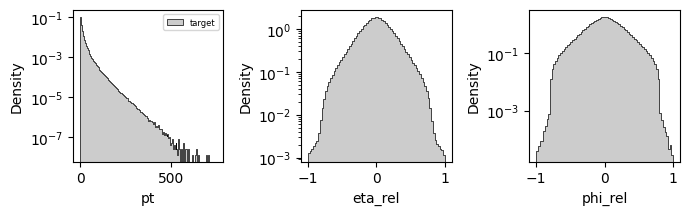

In [3]:
import matplotlib.pyplot as plt

mask_target = (coupling.target.mask > 0).squeeze() 

fig, ax = plt.subplots(1,3, figsize=(7,2.25))

binrange, binwidth = (-5, 750), 5
coupling.target.histplot('pt',  binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density', log_scale=(False,True), lw=0.5, color='k', alpha=0.2, label='target')
binrange, binwidth = (-1,1), 0.025
coupling.target.histplot('eta_rel', binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', log_scale=(False,True),  lw=0.5, color='k', alpha=0.2, label='target')
coupling.target.histplot('phi_rel',  binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density',log_scale=(False,True),  lw=0.5, color='k', alpha=0.2, label='target')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

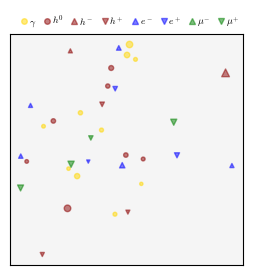

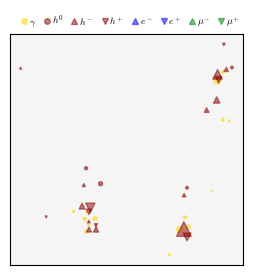

In [4]:
coupling.source.display_cloud(idx=10,  scale_marker=10.0)
coupling.target.display_cloud(idx=10,  scale_marker=1.0)

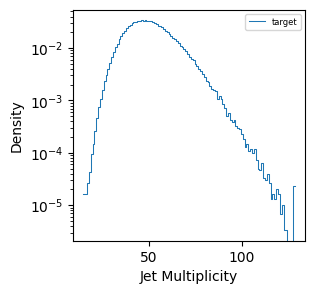

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(coupling.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True), color='r', ax=ax, label='source')
sns.histplot(coupling.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

### Preprocessed data (standardization)

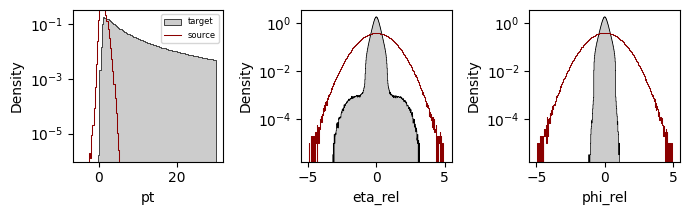

In [9]:


coupling.source.preprocess(stats_source)
coupling.target.preprocess(stats_target)

mask_target = (coupling.target.mask > 0).squeeze() 
mask_source = (coupling.source.mask > 0).squeeze() 

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))

binrange, binwidth = (-5, 30), 0.3
coupling.target.histplot('pt', binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density', log_scale=(False,True), lw=0.5, color='k', alpha=0.2, label='target')
coupling.source.histplot('pt', binwidth=binwidth, binrange=binrange, ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')

binrange, binwidth = (-5, 5), 0.02
coupling.target.histplot('eta_rel',  binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', log_scale=(False,True),  lw=0.5, color='k', alpha=0.2, label='target')
coupling.source.histplot('eta_rel',  binwidth=binwidth, binrange=binrange, ax=ax[1], stat='density', log_scale=(False,True),  color='darkred', fill=False, lw=0.75, label='source')
coupling.target.histplot('phi_rel', binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density', log_scale=(False,True), lw=0.5, color='k', alpha=0.2, label='target')
coupling.source.histplot('phi_rel',  binwidth=binwidth, binrange=binrange, ax=ax[2], stat='density', log_scale=(False,True),  color='darkred', fill=False, lw=0.75, label='source')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()


## Generate data from pretrained model

In [1]:
from cmb.models.trainers import GenerativeDynamicsModule
path='/home/df630/CMB/results/runs/JetClass/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h07_1979/config.yaml'
epic_cmb = GenerativeDynamicsModule(config=path, device='cuda:1')
epic_cmb.load(checkpoint='best')

2024-10-07 02:17:01.603725: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 02:17:01.648353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 02:17:01.649328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 02:17:02.354905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Conditional Markov Bridge initialized...
      - continuous process:  FlowMatching
      - discrete process:  TelegraphProcess
      - solver method:  EulerLeapingSolver
INFO: loading `best` epoch checkpoint on cuda:1 from:
  - /home/df630/CMB/results/runs/JetClass/gauss_to_tbqq_FlowMatching_TelegraphProcess_HybridEPiC_2024.10.06_03h07_1979/best_epoch.ckpt


In [3]:
from cmb.datasets.jetclass import JetsClassData, ParticleClouds

epic_cmb.config.data.source.test.num_jets = 10

source_stats = epic_cmb.config.data.source.train.stats.to_dict()
target_stats = epic_cmb.config.data.target.train.stats.to_dict()

test = JetsClassData(epic_cmb.config.data, task='test')
test.source.preprocess(source_stats)

epic_cmb.generate(source_continuous=test.source.continuous, 
                  source_discrete=test.source.discrete,
                  mask=test.source.mask,
                  output_history=True
                )

INFO: Loading test datasets.
INFO: generating samples...


In [13]:
epic_cmb.trajectories.shape, epic_cmb.jumps.shape

(torch.Size([1000, 10, 128, 3]), torch.Size([1000, 10, 128, 1]))

In [50]:
import numpy as np  
import matplotlib.pyplot as plt

def plot_trajectories(paths, jumps, idx=0, timesteps=[0, 0.2, 0.4, 0.6, 0.8, 1.0], title='CMB', color='darkblue', cmap='tab10', show_paths=False):
    """ Plot trajectories of some selected samples.
    """
    _, ax = plt.subplots(1, len(timesteps), figsize=(2.4*len(timesteps), 2.75))

    jumps = jumps.squeeze() 
    # mask = mask.squeeze()

    for j, time in enumerate(timesteps):

        idx_path = int(time * len(paths)) if time < 1 else -1 
        vmin = jumps.min() if jumps is not None else None 
        vmax = jumps.max() if jumps is not None else None
        color = jumps[idx_path, idx, :] if jumps is not None else color

        if show_paths:
            for i in range(128):
                ax[j].plot(paths[:idx_path, idx, i, 1], paths[:idx_path, idx, i, 2], alpha=0.3, lw=0.2, color='k')  # Plot lines for each trajectory

        ax[j].scatter(paths[0, idx, :, 1], paths[0, idx, :,  2], s=paths[0, idx, :, 0], color='gray', alpha=0.2, vmin=vmin, vmax=vmax)
        ax[j].scatter(paths[idx_path, idx, :, 1], paths[idx_path, idx, :, 2], s=paths[idx_path, idx, :, 0], c=color, cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        ax[j].text(0.125, 0.95, f't={idx_path/len(paths) if time < 1 else 1:.1f}', horizontalalignment='center', verticalalignment='center', transform=ax[j].transAxes, fontsize=10)
        ax[j].set_xlim(-1.25, 1.25)
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].axis('equal')

    ax[0].set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3197085/911287793.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax[j].scatter(paths[0, idx, :, 1], paths[0, idx, :,  2], s=paths[0, idx, :, 0], color='gray', alpha=0.2, vmin=vmin, vmax=vmax)


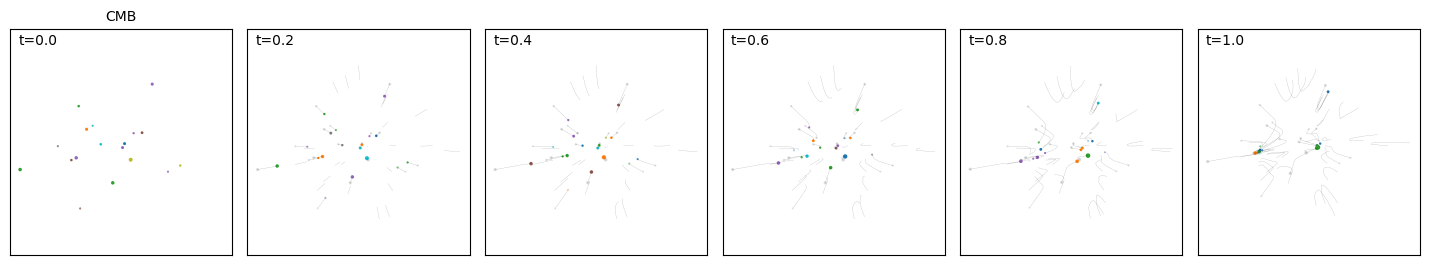

In [53]:
plot_trajectories(epic_cmb.trajectories, jumps=epic_cmb.jumps, idx=5, timesteps=[0, 0.2, 0.4, 0.6, 0.8, 1.0], title='CMB', color='darkblue', cmap='tab10', show_paths=True)

In [3]:
from cmb.datasets.jetclass import JetClassHighLevelFeatures, ParticleClouds

gen_sample = ParticleClouds(epic_cmb.sample, min_num_particles=0, max_num_particles=128, discrete_features=True) 
gen_sample.postprocess(target_stats)

gen_jets = JetClassHighLevelFeatures(gen_sample)
test_jets = JetClassHighLevelFeatures(test.target)


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#-----------------------

Calculating N-subjettiness
Calculating D2
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
Calculating N-subjettiness
Calculating D2


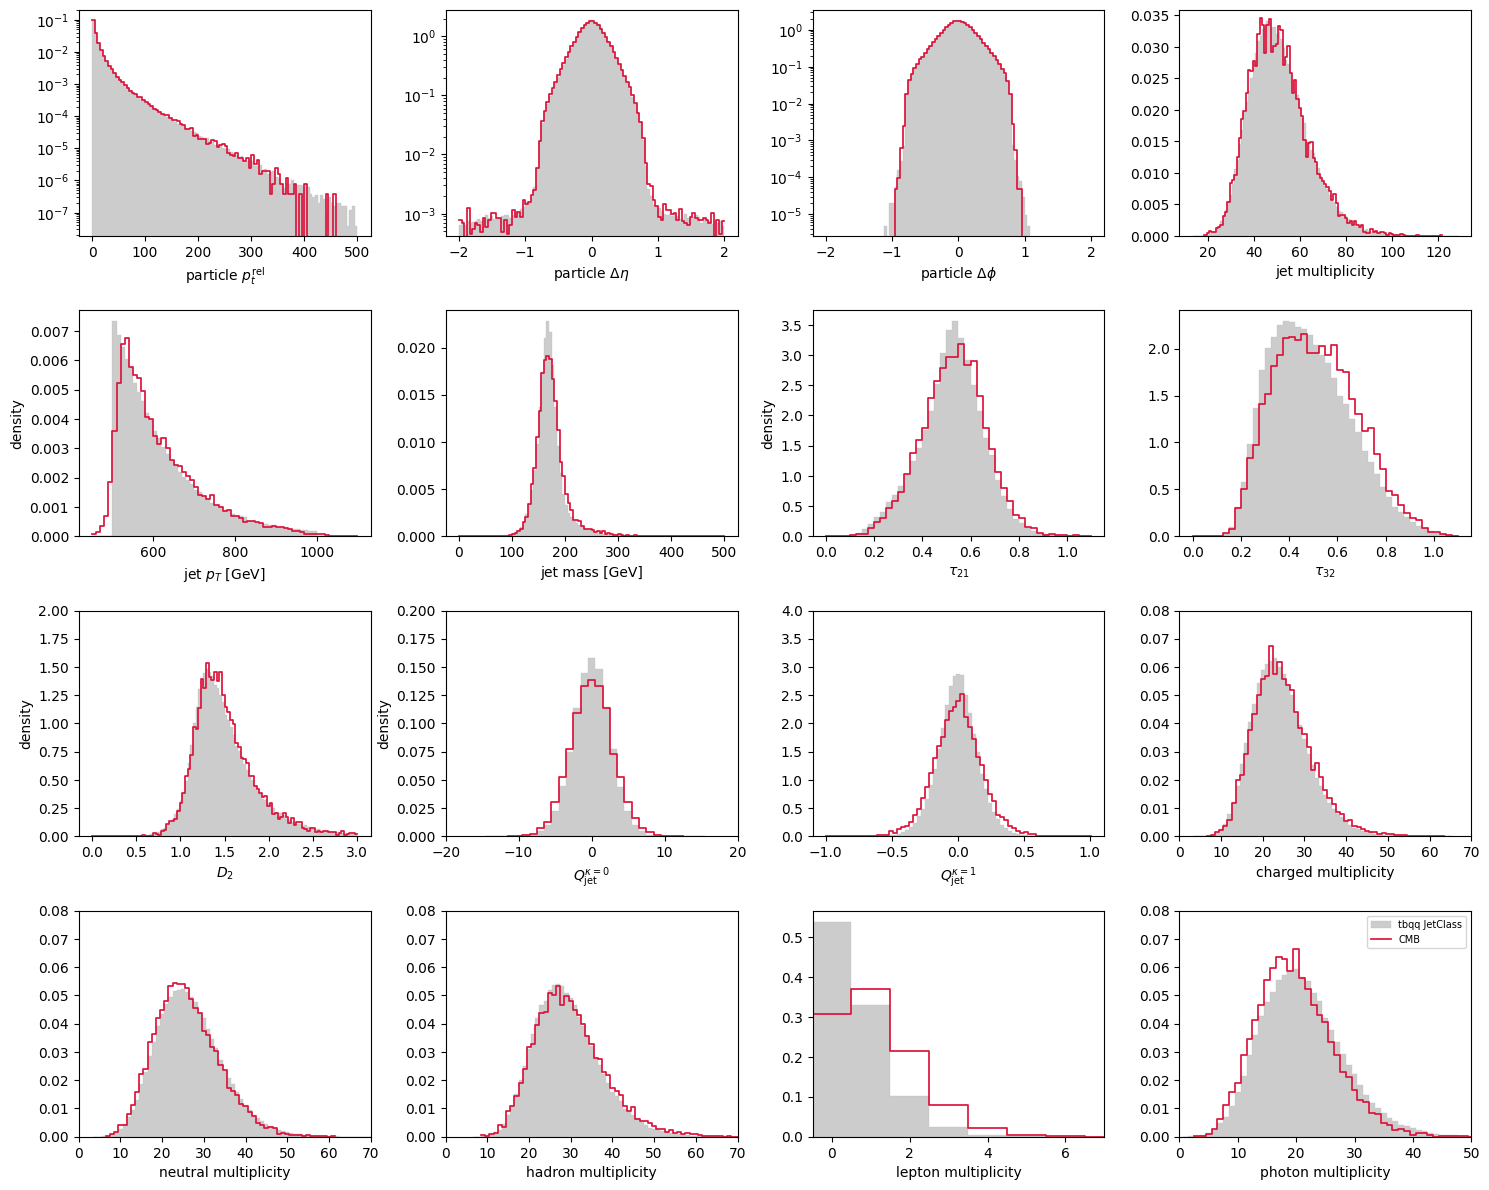

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_, ax = plt.subplots(4,4,figsize=(15,12))

arg_test = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, False), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.25,  label='CMB')
arg_test_log = dict(stat='density', fill=True, alpha=0.8, log_scale=(False, True), color='silver', lw=0.25, label='tbqq JetClass')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.25,  label='CMB')


mask_gen = (gen_jets.constituents.mask > 0).squeeze() 
mask_test = (test_jets.constituents.mask > 0).squeeze() 

binrange, binwidth = (0, 500), 5
test_jets.constituents.histplot('pt', mask=mask_test,  binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)
gen_jets.constituents.histplot('pt', mask=mask_gen, binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_gen_log)

binrange, binwidth = (-2, 2), 0.04
test_jets.constituents.histplot('eta_rel', mask=mask_test,  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)
gen_jets.constituents.histplot('eta_rel', mask=mask_gen, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_gen_log)

binrange, binwidth = (-2, 2), 0.04
test_jets.constituents.histplot('phi_rel', mask=mask_test,  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)
gen_jets.constituents.histplot('phi_rel', mask=mask_gen, binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_gen_log)


test_jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)
gen_jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_gen)

# ------------------------------

binrange, binwidth = (450, 1100), 10
test_jets.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('pt', xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth = (0, 500), 5
test_jets.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('m', xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth, ylim = (0, 1.1), 0.025, (0, 4.0)
test_jets.histplot('tau21',  xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('tau21', xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_gen)

test_jets.histplot('tau32',  xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('tau32', xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_gen)


# ------------------------------

binrange, binwidth, ylim = (0, 3.0), 0.03, (0, 2.0)
test_jets.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('d2', xlabel=r'$D_2$', ylabel='density', ax=ax[2,0],  ylim=ylim, binrange=binrange, binwidth=binwidth, **arg_gen)

xlim, ylim = (-20, 20), (0, 0.2)
test_jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$',  discrete=True, ax=ax[2,1], **arg_test)
gen_jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$', ylim=ylim, xlim=xlim, ylabel='density', discrete=True, ax=ax[2,1], **arg_gen)

binrange, binwidth, ylim = (-1, 1), 0.03, (0.0, 4.0)
test_jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', binrange=binrange, binwidth=binwidth , ax=ax[2,2], **arg_test)
gen_jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', ylim=ylim, binrange=binrange, binwidth=binwidth, ax=ax[2,2], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', ax=ax[2,3], **arg_test)
gen_jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', xlim=xlim, ylim=ylim, ax=ax[2,3], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', ax=ax[3,0], **arg_test)
gen_jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,0], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', ax=ax[3,1], **arg_test)
gen_jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,1], **arg_gen)

xlim = (-0.5,7)
test_jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', ax=ax[3,2], **arg_test)
gen_jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', xlim=xlim, ax=ax[3,2], **arg_gen)   

xlim, ylim = (0, 50), (0, 0.08)
test_jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', ax=ax[3,3], **arg_test)
gen_jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,3], **arg_gen)

plt.legend(fontsize=7)

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'all_features.png')
plt.show()

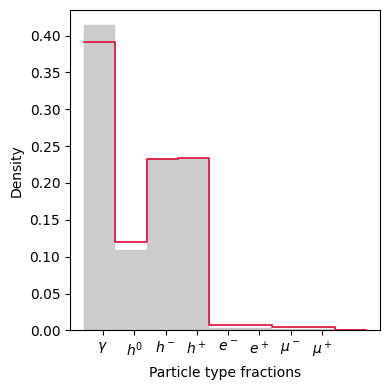

In [10]:
_, ax = plt.subplots(1,1,figsize=(4,4))

sns.histplot(test_jets.constituents.discrete[mask_test].squeeze(), binrange=(-0.1, 7.1), element='step',  ax=ax, discrete=True, **arg_test)
sns.histplot(gen_jets.constituents.discrete[mask_gen].squeeze(), binrange=(-0.1, 7.1), element='step', ax=ax, discrete=True, **arg_gen)
ax.set_xlabel('Particle type fractions')
ax.set_xticks(np.arange(8))
ax.set_xticklabels([r'$\gamma$', r'$h^0$', r'$h^-$', r'$h^+$', r'$e^-$', r'$e^+$', r'$\mu^-$', r'$\mu^+$'])

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fractions.png')
plt.show()

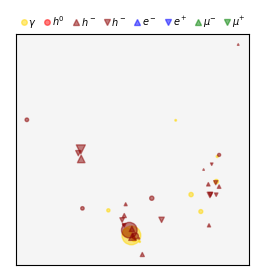

In [13]:
gen_jets.constituents.display_cloud(idx=104, scale_marker=1.0)

In [11]:
from cmb.datasets.jetclass import JetsClassData, ParticleClouds

epic_cmb.config.data.source.test.num_jets = 10

source_stats = epic_cmb.config.data.source.train.stats.to_dict()
target_stats = epic_cmb.config.data.target.train.stats.to_dict()

test = JetsClassData(epic_cmb.config.data, task='test')
test.source.preprocess(source_stats)

epic_cmb.generate(source_continuous=test.source.continuous, 
                  source_discrete=test.source.discrete,
                  mask=test.source.mask,
                  output_history=True
                )

INFO: Loading test datasets.
INFO: generating samples...


AttributeError: 'tuple' object has no attribute 'append'